In [89]:
import pandas as pd
from sqlalchemy import create_engine, text
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


In [90]:
db_user = 'postgres'
db_password = '123456'
db_host = 'localhost'
db_port = '5432'
db_name = 'nordic_co2'

engine = create_engine(f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')

# norway

## General Analysis

In [91]:
query_no_general = '''
WITH no_2021_summary AS (
    SELECT 
        '2021' AS year_,
        country,
        zone_id,
        EXTRACT(MONTH FROM datetime_utc) AS month_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM norway.year_2021_hourly
    GROUP BY country, zone_id, EXTRACT(MONTH FROM datetime_utc)
), no_2022_summary AS (
    SELECT 
        '2022' AS year_,
        country,
        zone_id,
        EXTRACT(MONTH FROM datetime_utc) AS month_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM norway.year_2022_hourly
    GROUP BY country, zone_id, EXTRACT(MONTH FROM datetime_utc)
), no_2023_summary AS (
    SELECT 
        '2023' AS year_,
        country,
        zone_id,
        EXTRACT(MONTH FROM datetime_utc) AS month_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM norway.year_2023_hourly
    GROUP BY country, zone_id, EXTRACT(MONTH FROM datetime_utc)
), no_2024_summary AS (
    SELECT 
        '2024' AS year_,
        country,
        zone_id,
        EXTRACT(MONTH FROM datetime_utc) AS month_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM norway.year_2024_hourly
    GROUP BY country, zone_id, EXTRACT(MONTH FROM datetime_utc)
), total_summary AS (
    SELECT * FROM no_2021_summary
    UNION ALL
    SELECT * FROM no_2022_summary
    UNION ALL
    SELECT * FROM no_2023_summary
    UNION ALL
    SELECT * FROM no_2024_summary
), with_differences AS (
    SELECT 
        *,
        LEAD(total_direct_carbon_emission) OVER (PARTITION BY country, zone_id ORDER BY year_, month_grouped) AS next_direct_carbon_emission,
        LEAD(total_lca_carbon_emission) OVER (PARTITION BY country, zone_id ORDER BY year_, month_grouped) AS next_lca_carbon_emission
    FROM total_summary
)

SELECT 
    year_,
    country,
    zone_id,
    month_grouped,
    total_direct_carbon_emission,
    next_direct_carbon_emission,
    CASE 
        WHEN next_direct_carbon_emission IS NOT NULL AND total_direct_carbon_emission != 0 
        THEN ROUND(((next_direct_carbon_emission - total_direct_carbon_emission) / total_direct_carbon_emission) * 100::NUMERIC, 2)
        ELSE NULL 
    END AS direct_decrease_or_increase,
    total_lca_carbon_emission,
    next_lca_carbon_emission,
    CASE 
        WHEN next_lca_carbon_emission IS NOT NULL AND total_lca_carbon_emission != 0 
        THEN ROUND(((next_lca_carbon_emission - total_lca_carbon_emission) / total_lca_carbon_emission) * 100::NUMERIC, 2)
        ELSE NULL 
    END AS lca_decrease_or_increase,
    avg_renewable_percentage,
    avg_low_carbon_percentage
FROM with_differences
ORDER BY year_, month_grouped;
'''

no_general = pd.read_sql_query(query_no_general, engine)

In [92]:
no_general.head()

,year_,country,zone_id,month_grouped,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
0,2021,Norway,NO,1.0,4559.45,5329.50,16.89,22849.49,21780.15,-4.68,98.53,99.00
1,2021,Norway,NO,2.0,5329.50,4723.50,-11.37,21780.15,22706.83,4.25,97.88,98.79
2,2021,Norway,NO,3.0,4723.50,4551.16,-3.65,22706.83,22222.72,-2.13,97.85,98.95
3,2021,Norway,NO,4.0,4551.16,5808.24,27.62,22222.72,24825.77,11.71,97.50,98.89
4,2021,Norway,NO,5.0,5808.24,3398.10,-41.50,24825.77,21124.48,-14.91,97.38,98.62


In [93]:
no_general.rename(columns={'year_':'year'}, inplace=True)
no_general.rename(columns={'month_grouped':'month'}, inplace=True)

In [94]:
no_general.dtypes

year                             object
country                          object
zone_id                          object
month                           float64
total_direct_carbon_emission    float64
next_direct_carbon_emission     float64
direct_decrease_or_increase     float64
total_lca_carbon_emission       float64
next_lca_carbon_emission        float64
lca_decrease_or_increase        float64
avg_renewable_percentage        float64
avg_low_carbon_percentage       float64
dtype: object

In [95]:
no_general.year = no_general.year.astype(int)
no_general.month = no_general.month.astype(int)

### Statistics

In [96]:
no_general.describe()

,year,month,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
count,48.000000,48.000000,48.000000,47.00000,47.000000,48.000000,47.000000,47.000000,48.000000,48.000000
mean,2022.500000,6.500000,6875.502292,6924.78000,8.684894,25050.047500,25096.867872,1.010213,96.680208,98.188542
std,1.129865,3.488583,2967.109129,2979.26673,47.934247,3519.262319,3542.166058,15.467226,1.334963,0.730835
min,2021.000000,1.000000,2520.160000,2520.16000,-56.160000,20091.070000,20091.070000,-27.350000,91.300000,95.010000
25%,2021.750000,3.750000,4980.167500,5005.16500,-19.645000,22706.420000,22706.010000,-8.195000,96.037500,97.937500
50%,2022.500000,6.500000,6043.325000,6075.40000,-5.350000,24618.150000,24618.670000,-1.310000,96.930000,98.245000
75%,2023.250000,9.250000,7832.987500,7869.70500,23.985000,26272.872500,26297.125000,7.765000,97.552500,98.662500
max,2024.000000,12.000000,19310.040000,19310.04000,153.250000,39375.130000,39375.130000,41.560000,98.810000,99.330000


<Axes: >

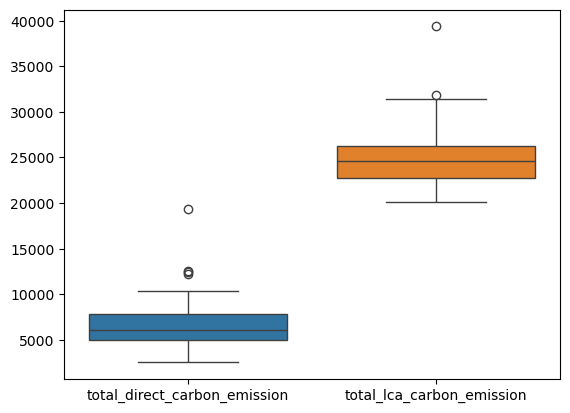

In [97]:
sns.boxplot(no_general[['total_direct_carbon_emission', 'total_lca_carbon_emission']])

<Axes: >

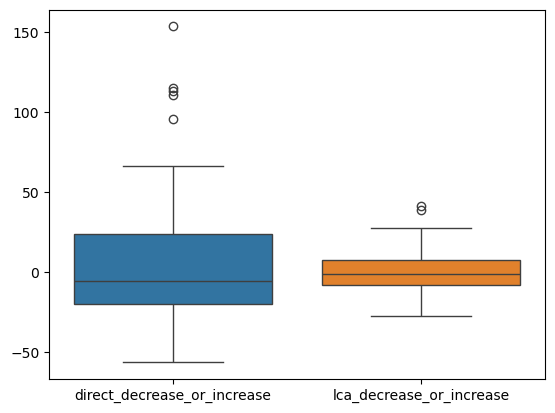

In [98]:
sns.boxplot(no_general[['direct_decrease_or_increase', 'lca_decrease_or_increase']])

In [99]:
no_general[no_general['direct_decrease_or_increase'] > 100]

,year,country,zone_id,month,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
10,2021,Norway,NO,11,4251.00,9124.22,114.64,21691.99,27632.78,27.39,98.05,98.96
19,2022,Norway,NO,8,9055.44,19310.04,113.24,28310.16,39375.13,39.08,95.64,97.32
22,2022,Norway,NO,11,4818.29,12202.32,153.25,22124.59,31320.15,41.56,97.80,98.45
29,2023,Norway,NO,6,2520.16,5303.99,110.46,20091.07,24135.15,20.13,98.62,99.33


In [100]:
no_general.loc[[33, 34]]

,year,country,zone_id,month,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
33,2023,Norway,NO,10,5750.23,7568.38,31.62,23684.81,25596.02,8.07,97.0,98.26
34,2023,Norway,NO,11,7568.38,12565.12,66.02,25596.02,31861.70,24.48,96.3,97.94


In [101]:
no_general.select_dtypes(include='number').corr()

,year,month,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
year,1.000000e+00,4.864312e-14,-0.004162,-0.075036,-0.148839,-0.012452,-0.079148,-0.103561,-0.255249,-0.211672
month,4.864312e-14,1.000000e+00,0.067867,0.229283,0.165214,0.082191,0.250543,0.137407,-0.057679,-0.124718
total_direct_carbon_emission,-4.161822e-03,6.786686e-02,1.000000,0.374058,-0.436483,0.985866,0.333390,-0.496100,-0.890802,-0.938683
next_direct_carbon_emission,-7.503571e-02,2.292828e-01,0.374058,1.000000,0.586406,0.372613,0.985978,0.571808,-0.265039,-0.388957
direct_decrease_or_increase,-1.488389e-01,1.652138e-01,-0.436483,0.586406,1.000000,-0.438460,0.616839,0.951801,0.469563,0.384245
total_lca_carbon_emission,-1.245237e-02,8.219079e-02,0.985866,0.372613,-0.438460,1.000000,0.331591,-0.518708,-0.864227,-0.927516
next_lca_carbon_emission,-7.914811e-02,2.505428e-01,0.333390,0.985978,0.616839,0.331591,1.000000,0.621614,-0.235824,-0.357332
lca_decrease_or_increase,-1.035611e-01,1.374070e-01,-0.496100,0.571808,0.951801,-0.518708,0.621614,1.000000,0.488924,0.425737
avg_renewable_percentage,-2.552495e-01,-5.767868e-02,-0.890802,-0.265039,0.469563,-0.864227,-0.235824,0.488924,1.000000,0.923096
avg_low_carbon_percentage,-2.116723e-01,-1.247182e-01,-0.938683,-0.388957,0.384245,-0.927516,-0.357332,0.425737,0.923096,1.000000


In [102]:
#sns.pairplot(no_general)

## Hourly Analysis

In [103]:
query_no_hourly = '''
WITH no_2021_summary AS (
    SELECT 
        '2021' AS year_,
        country,
        zone_id,
        EXTRACT(HOUR FROM datetime_utc) AS hour_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM norway.year_2021_hourly
    GROUP BY country, zone_id, EXTRACT(HOUR FROM datetime_utc)
), no_2022_summary AS (
    SELECT 
        '2022' AS year_,
        country,
        zone_id,
        EXTRACT(HOUR FROM datetime_utc) AS hour_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM norway.year_2022_hourly
    GROUP BY country, zone_id, EXTRACT(HOUR FROM datetime_utc)
), no_2023_summary AS (
    SELECT 
        '2023' AS year_,
        country,
        zone_id,
        EXTRACT(HOUR FROM datetime_utc) AS hour_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM norway.year_2023_hourly
    GROUP BY country, zone_id, EXTRACT(HOUR FROM datetime_utc)
), no_2024_summary AS (
    SELECT 
        '2024' AS year_,
        country,
        zone_id,
        EXTRACT(HOUR FROM datetime_utc) AS hour_grouped,
        ROUND(SUM(carbon_intensity_direct)::NUMERIC, 2) AS total_direct_carbon_emission,
        ROUND(SUM(carbon_intensity_lca)::NUMERIC, 2) AS total_lca_carbon_emission,
        ROUND(AVG(renewable_percentage)::NUMERIC, 2) AS avg_renewable_percentage,
        ROUND(AVG(low_carbon_percentage)::NUMERIC, 2) AS avg_low_carbon_percentage
    FROM norway.year_2024_hourly
    GROUP BY country, zone_id, EXTRACT(HOUR FROM datetime_utc)
), total_summary AS (
    SELECT * FROM no_2021_summary
    UNION ALL
    SELECT * FROM no_2022_summary
    UNION ALL
    SELECT * FROM no_2023_summary
    UNION ALL
    SELECT * FROM no_2024_summary
), with_differences AS (
    SELECT 
        *,
        LEAD(total_direct_carbon_emission) OVER (PARTITION BY country, zone_id ORDER BY year_, hour_grouped) AS next_direct_carbon_emission,
        LEAD(total_lca_carbon_emission) OVER (PARTITION BY country, zone_id ORDER BY year_, hour_grouped) AS next_lca_carbon_emission
    FROM total_summary
)

SELECT 
    year_,
    country,
    zone_id,
    hour_grouped,
    total_direct_carbon_emission,
    next_direct_carbon_emission,
    CASE 
        WHEN next_direct_carbon_emission IS NOT NULL AND total_direct_carbon_emission != 0 
        THEN ROUND(((next_direct_carbon_emission - total_direct_carbon_emission) / total_direct_carbon_emission) * 100::NUMERIC, 2)
        ELSE NULL 
    END AS direct_decrease_or_increase,
    total_lca_carbon_emission,
    next_lca_carbon_emission,
    CASE 
        WHEN next_lca_carbon_emission IS NOT NULL AND total_lca_carbon_emission != 0 
        THEN ROUND(((next_lca_carbon_emission - total_lca_carbon_emission) / total_lca_carbon_emission) * 100::NUMERIC, 2)
        ELSE NULL 
    END AS lca_decrease_or_increase,
    avg_renewable_percentage,
    avg_low_carbon_percentage
FROM with_differences
ORDER BY year_, hour_grouped
'''

no_hourly = pd.read_sql_query(query_no_hourly, engine)

In [104]:
no_hourly.head(20)

,year_,country,zone_id,hour_grouped,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
0,2021,Norway,NO,0.0,3328.86,3582.79,7.63,12394.39,12684.67,2.34,96.78,98.49
1,2021,Norway,NO,1.0,3582.79,3637.74,1.53,12684.67,12747.93,0.50,96.58,98.39
2,2021,Norway,NO,2.0,3637.74,3409.70,-6.27,12747.93,12491.07,-2.01,96.56,98.37
3,2021,Norway,NO,3.0,3409.70,3132.12,-8.14,12491.07,12186.76,-2.44,96.90,98.46
4,2021,Norway,NO,4.0,3132.12,2816.71,-10.07,12186.76,11837.65,-2.86,97.44,98.59
5,2021,Norway,NO,5.0,2816.71,2575.73,-8.56,11837.65,11574.07,-2.23,97.92,98.72
6,2021,Norway,NO,6.0,2575.73,2529.02,-1.81,11574.07,11530.31,-0.38,98.23,98.82
7,2021,Norway,NO,7.0,2529.02,2595.71,2.64,11530.31,11622.47,0.80,98.33,98.84
8,2021,Norway,NO,8.0,2595.71,2648.86,2.05,11622.47,11691.16,0.59,98.26,98.80
9,2021,Norway,NO,9.0,2648.86,2716.43,2.55,11691.16,11776.28,0.73,98.19,98.78


In [105]:
no_hourly

,year_,country,zone_id,hour_grouped,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
0,2021,Norway,NO,0.0,3328.86,3582.79,7.63,12394.39,12684.67,2.34,96.78,98.49
1,2021,Norway,NO,1.0,3582.79,3637.74,1.53,12684.67,12747.93,0.50,96.58,98.39
2,2021,Norway,NO,2.0,3637.74,3409.70,-6.27,12747.93,12491.07,-2.01,96.56,98.37
3,2021,Norway,NO,3.0,3409.70,3132.12,-8.14,12491.07,12186.76,-2.44,96.90,98.46
4,2021,Norway,NO,4.0,3132.12,2816.71,-10.07,12186.76,11837.65,-2.86,97.44,98.59
...,...,...,...,...,...,...,...,...,...,...,...,...
91,2024,Norway,NO,19.0,2670.25,2736.31,2.47,11605.81,11643.63,0.33,97.03,98.33
92,2024,Norway,NO,20.0,2736.31,2873.46,5.01,11643.63,11769.40,1.08,96.70,98.30
93,2024,Norway,NO,21.0,2873.46,3034.42,5.60,11769.40,11924.01,1.31,96.34,98.22
94,2024,Norway,NO,22.0,3034.42,3236.71,6.67,11924.01,12145.55,1.86,96.03,98.15


In [106]:
no_hourly.rename(columns={'year_':'year'}, inplace=True)
no_hourly.rename(columns={'hour_grouped':'hour'}, inplace=True)

In [107]:
no_hourly.year = no_hourly.year.astype(int)
no_hourly.hour = no_hourly.hour.astype(int)

In [108]:
#no_hourly.to_excel('no_hourly.xlsx')

In [109]:
no_hourly.describe()

,year,hour,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
count,96.000000,96.000000,96.000000,95.000000,95.000000,96.000000,95.000000,95.000000,96.000000,96.000000
mean,2022.500000,11.500000,3437.751146,3438.897368,0.582947,12525.023750,12526.398842,0.044211,96.678542,98.187708
std,1.123903,6.958524,945.021118,949.967438,12.038485,1073.179984,1078.788261,3.707743,1.078995,0.468854
min,2021.000000,0.000000,1895.920000,1895.920000,-27.990000,10787.160000,10787.160000,-11.710000,93.810000,96.960000
25%,2021.750000,5.750000,2740.337500,2738.995000,-7.345000,11763.710000,11758.020000,-2.175000,96.030000,97.915000
50%,2022.500000,11.500000,3197.765000,3191.870000,2.470000,12240.835000,12239.030000,0.590000,96.700000,98.215000
75%,2023.250000,17.250000,3868.860000,3869.500000,6.610000,13062.537500,13062.955000,1.825000,97.447500,98.490000
max,2024.000000,23.000000,5925.310000,5925.310000,82.870000,15318.700000,15318.700000,23.120000,98.690000,99.080000


<Axes: >

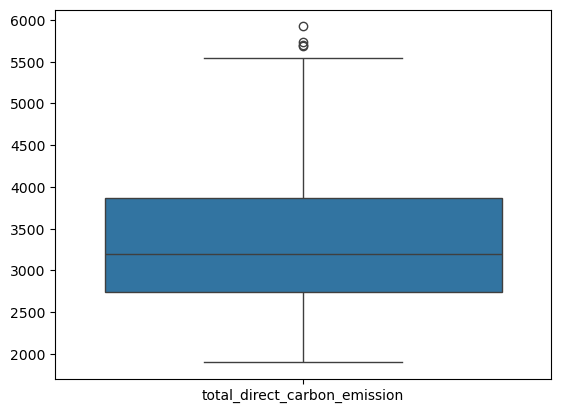

In [110]:
sns.boxplot(no_hourly[['total_direct_carbon_emission']])

In [141]:
no_hourly.total_direct_carbon_emission.max()

5925.31

In [143]:
q1 = no_hourly.total_direct_carbon_emission.quantile(0.25)
q3 = no_hourly.total_direct_carbon_emission.quantile(0.75)

iqr = q3 - q1

inferior_limit = q1 - 1.5 * iqr
superior_limit = q3 + 1.5 * iqr

print(f'IL: {inferior_limit} | SL: {superior_limit}')

IL: 1047.5537499999996 | SL: 5561.643749999999


In [146]:
no_hourly[(no_hourly.total_direct_carbon_emission < inferior_limit) | (no_hourly.total_direct_carbon_emission > superior_limit)]

,year,country,zone_id,hour,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
25,2022,Norway,NO,1,5740.12,5925.31,3.23,15089.11,15318.70,1.52,93.94,97.08
26,2022,Norway,NO,2,5925.31,5687.87,-4.01,15318.70,15074.52,-1.59,93.81,96.96
27,2022,Norway,NO,3,5687.87,5059.90,-11.04,15074.52,14394.78,-4.51,94.17,97.04
36,2022,Norway,NO,12,5698.22,5469.21,-4.02,15130.99,14859.34,-1.80,95.21,97.40


In [ ]:
no_hourly[(no_hourly.direct_decrease_or_increase >= inferior_limit) & (no_hourly.direct_decrease_or_increase <= superior_limit)].max()

<Axes: >

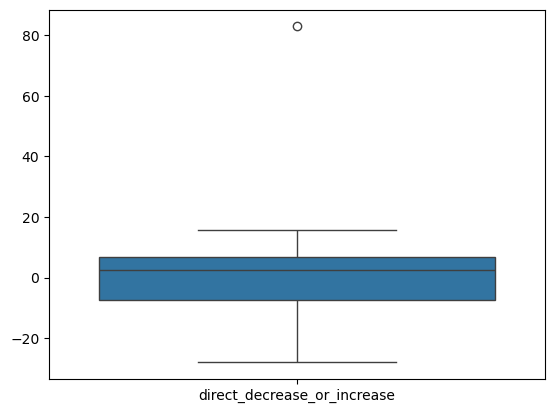

In [111]:
sns.boxplot(no_hourly[['direct_decrease_or_increase']])

In [112]:
no_hourly.select_dtypes(include='number').corr()

,year,hour,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
year,1.000000e+00,2.451147e-14,-0.006499,-0.032336,-0.089194,-0.020310,-0.043566,-0.072797,-0.314135,-0.325210
hour,2.451147e-14,1.000000e+00,-0.347785,-0.261040,0.248017,-0.349223,-0.273558,0.187081,0.304439,0.320803
total_direct_carbon_emission,-6.499017e-03,-3.477852e-01,1.000000,0.902588,-0.185687,0.997888,0.902465,-0.201557,-0.888594,-0.933157
next_direct_carbon_emission,-3.233562e-02,-2.610401e-01,0.902588,1.000000,0.244509,0.899139,0.997887,0.238159,-0.819358,-0.830751
direct_decrease_or_increase,-8.919390e-02,2.480172e-01,-0.185687,0.244509,1.000000,-0.189751,0.238457,0.986996,0.131175,0.205332
total_lca_carbon_emission,-2.030968e-02,-3.492230e-01,0.997888,0.899139,-0.189751,1.000000,0.902907,-0.205389,-0.868032,-0.922942
next_lca_carbon_emission,-4.356571e-02,-2.735581e-01,0.902465,0.997887,0.238457,0.902907,1.000000,0.233849,-0.802138,-0.823610
lca_decrease_or_increase,-7.279665e-02,1.870809e-01,-0.201557,0.238159,0.986996,-0.205389,0.233849,1.000000,0.149410,0.217345
avg_renewable_percentage,-3.141354e-01,3.044387e-01,-0.888594,-0.819358,0.131175,-0.868032,-0.802138,0.149410,1.000000,0.958791
avg_low_carbon_percentage,-3.252103e-01,3.208034e-01,-0.933157,-0.830751,0.205332,-0.922942,-0.823610,0.217345,0.958791,1.000000


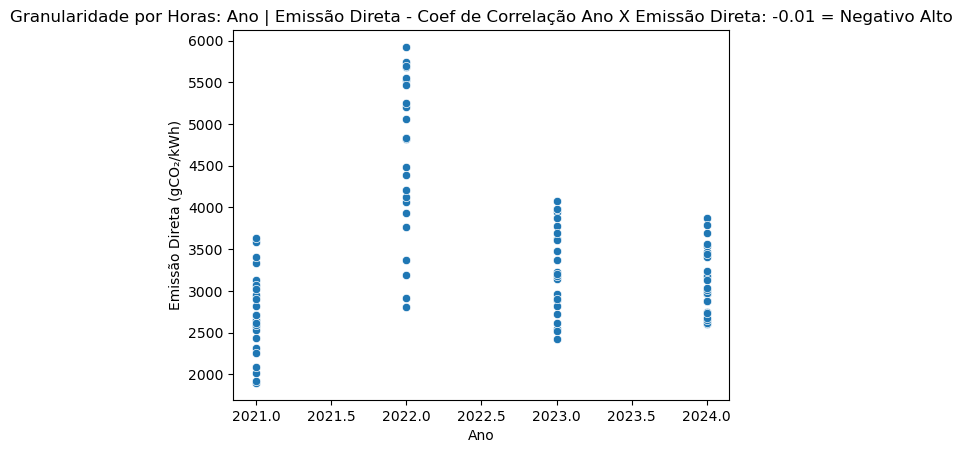

In [113]:
correlation = no_hourly.year.corr(no_hourly.total_direct_carbon_emission)

sns.scatterplot(data=no_hourly, x='year', y='total_direct_carbon_emission')
plt.title(f'Granularidade por Horas: Ano | Emissão Direta - Coef de Correlação Ano X Emissão Direta: {correlation:.2f} = Negativo Alto')
plt.xlabel('Ano')
plt.ylabel('Emissão Direta (gCO₂/kWh)')
plt.show()

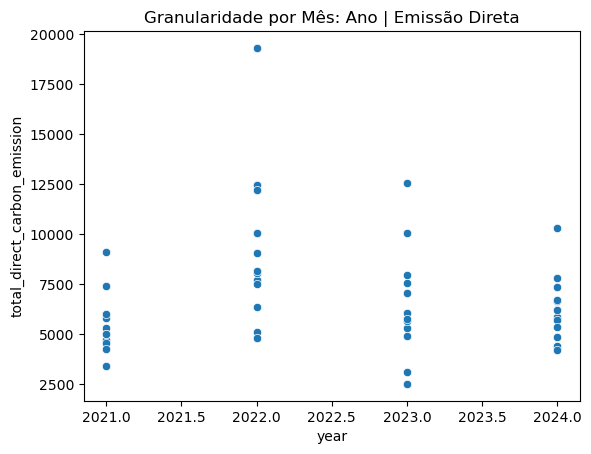

In [114]:
sns.scatterplot(data=no_general, x='year', y='total_direct_carbon_emission')
plt.title('Granularidade por Mês: Ano | Emissão Direta')
plt.show()

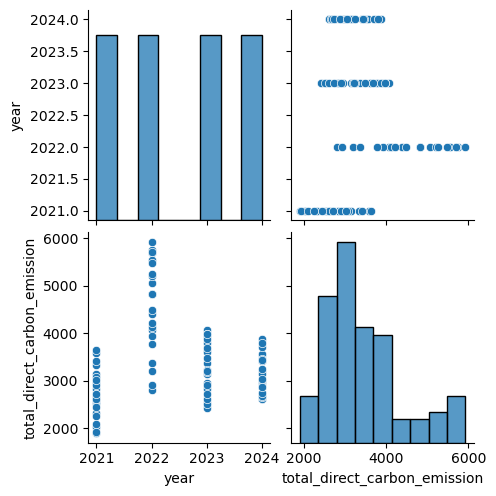

In [115]:
sns.pairplot(no_hourly[['year', 'total_direct_carbon_emission']])

### 2021

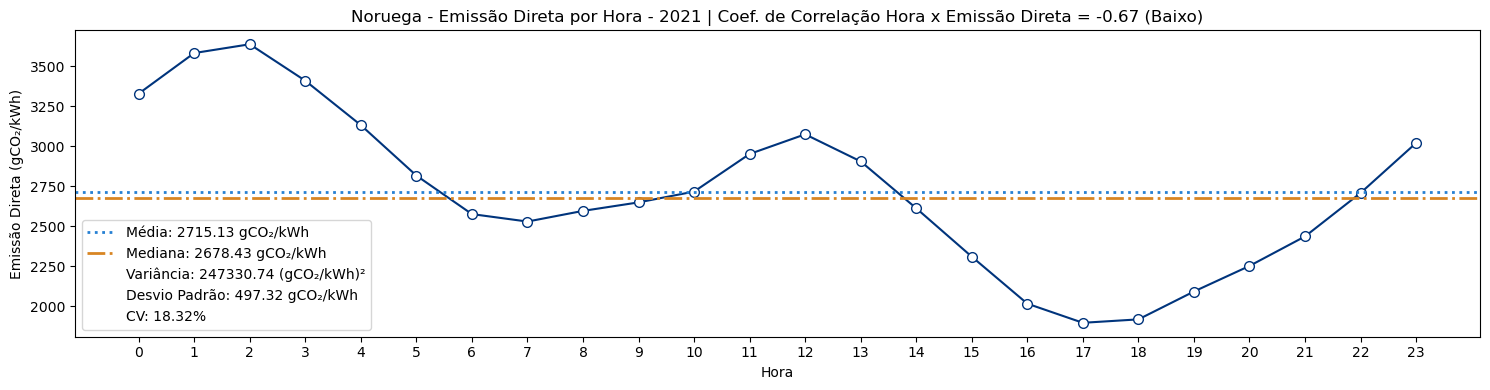

In [116]:
no_hourly_2021 = no_hourly[no_hourly.year == 2021]

correlation = no_hourly_2021.hour.corr(no_hourly_2021.total_direct_carbon_emission)
mean = no_hourly_2021.total_direct_carbon_emission.mean()
median = no_hourly_2021.total_direct_carbon_emission.median()
std = no_hourly_2021.total_direct_carbon_emission.std()
variance = std**2
cv = (std/mean)*100

plt.figure(figsize=(15, 4))
plt.plot(no_hourly_2021.hour, no_hourly_2021.total_direct_carbon_emission, 
         linewidth=1.5, color='#00347c', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

plt.axhline(mean, color='#2680d3', linestyle='dotted', linewidth=2, label=f'Média: {mean:.2f} gCO₂/kWh')
plt.axhline(median, color='#d88523', linestyle='dashdot', linewidth=2, label=f'Mediana: {median:.2f} gCO₂/kWh')

custom_lines = [
    Line2D([0], [0], color='none', label=f'Variância: {variance:.2f} (gCO₂/kWh)²'),
    Line2D([0], [0], color='none', label=f'Desvio Padrão: {std:.2f} gCO₂/kWh'),
    Line2D([0], [0], color='none', label=f'CV: {cv:.2f}%')
]

plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_lines)

plt.title(f'Noruega - Emissão Direta por Hora - 2021 | Coef. de Correlação Hora x Emissão Direta = {correlation:.2f} (Baixo)')
plt.xlabel('Hora')
plt.ylabel('Emissão Direta (gCO₂/kWh)')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

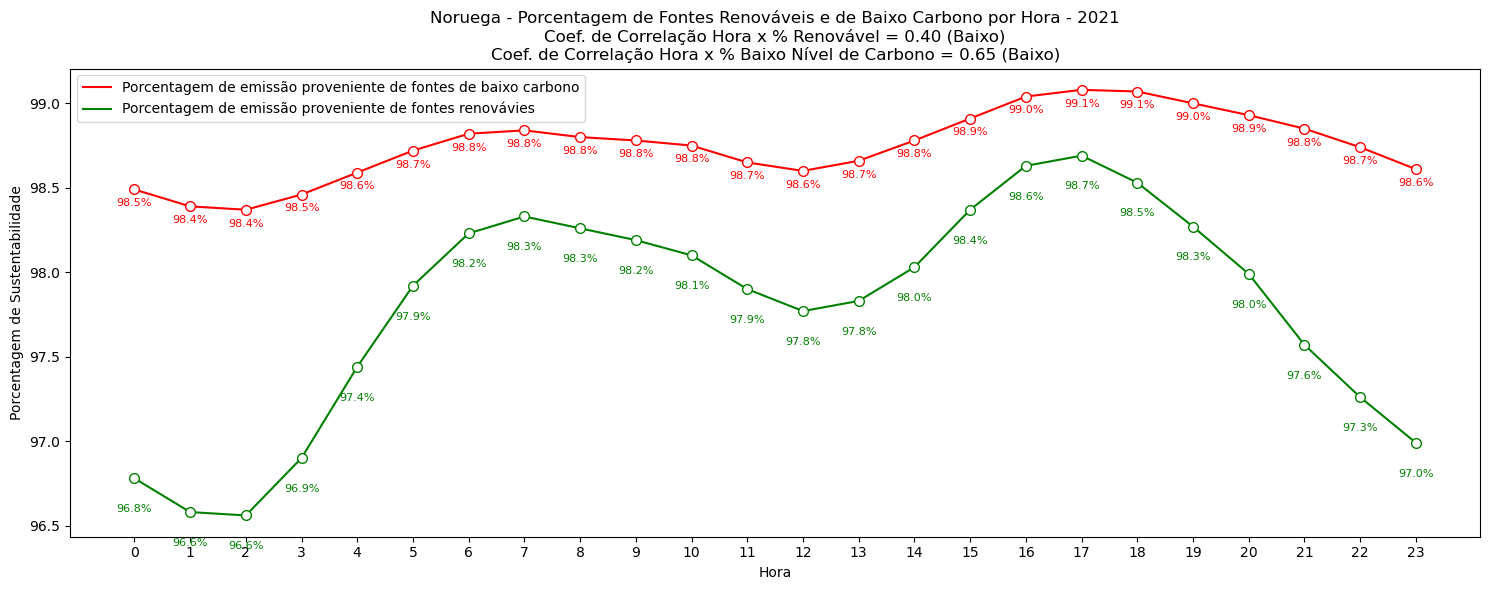

In [139]:
no_hourly_2021 = no_hourly[no_hourly.year == 2021]

correlation_renewable = no_hourly_2021.hour.corr(no_hourly_2021.avg_renewable_percentage)
correlation_low_carbon = no_hourly_2021.hour.corr(no_hourly_2021.avg_low_carbon_percentage)

plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=0.90)

plt.plot(no_hourly_2021.hour, no_hourly_2021.avg_renewable_percentage, 
         linewidth=1.5, color='green', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

for x, y in zip(no_hourly_2021.hour, no_hourly_2021.avg_renewable_percentage):
    plt.text(x, y - 0.2, f'{y:.1f}%', ha='center', fontsize=8, color='green')

plt.plot(no_hourly_2021.hour, no_hourly_2021.avg_low_carbon_percentage, 
         linewidth=1.5, color='red', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

for x, y in zip(no_hourly_2021.hour, no_hourly_2021.avg_low_carbon_percentage):
    plt.text(x, y - 0.1, f'{y:.1f}%', ha='center', fontsize=8, color='red')

custom_lines = [
    Line2D([0], [0], color='red', label='Porcentagem de emissão proveniente de fontes de baixo carbono'),
    Line2D([0], [0], color='green', label='Porcentagem de emissão proveniente de fontes renovávies'),
]

plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_lines)

plt.title(
    f'Noruega - Porcentagem de Fontes Renováveis e de Baixo Carbono por Hora - 2021\n'
    f'Coef. de Correlação Hora x % Renovável = {correlation_renewable:.2f} (Baixo)\n'
    f'Coef. de Correlação Hora x % Baixo Nível de Carbono = {correlation_low_carbon:.2f} (Baixo)'
)
plt.xlabel('Hora')
plt.ylabel('Porcentagem de Sustentabilidade')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

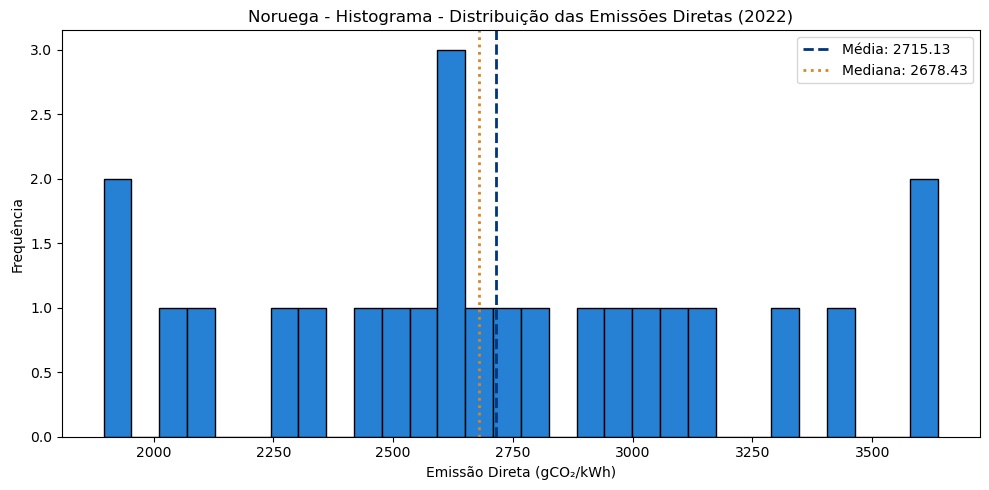

In [118]:
plt.figure(figsize=(10, 5))
plt.hist(no_hourly_2021.total_direct_carbon_emission, bins=30, color='#2680d3', edgecolor='black')
plt.axvline(no_hourly_2021.total_direct_carbon_emission.mean(), color='#00347c', linestyle='dashed', linewidth=2, label=f'Média: {no_hourly_2021.total_direct_carbon_emission.mean():.2f}')
plt.axvline(no_hourly_2021.total_direct_carbon_emission.median(), color='#d88523', linestyle='dotted', linewidth=2, label=f'Mediana: {no_hourly_2021.total_direct_carbon_emission.median():.2f}')
plt.title('Noruega - Histograma - Distribuição das Emissões Diretas (2022)')
plt.xlabel('Emissão Direta (gCO₂/kWh)')
plt.ylabel('Frequência')
plt.legend()
plt.tight_layout()
plt.show()

<Axes: ylabel='total_direct_carbon_emission'>

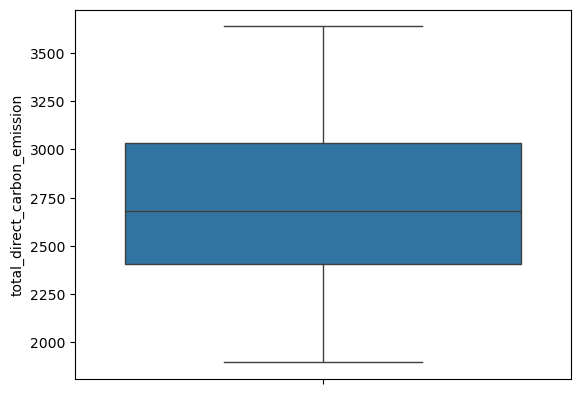

In [119]:
sns.boxplot(no_hourly_2021.total_direct_carbon_emission)

In [120]:
no_hourly.groupby('hour')['total_direct_carbon_emission'].max().reset_index().sort_values('total_direct_carbon_emission', ascending=False)

,hour,total_direct_carbon_emission
2,2,5925.31
1,1,5740.12
12,12,5698.22
3,3,5687.87
11,11,5548.34
0,0,5523.80
13,13,5469.21
23,23,5251.95
10,10,5207.25
4,4,5059.90


### 2022

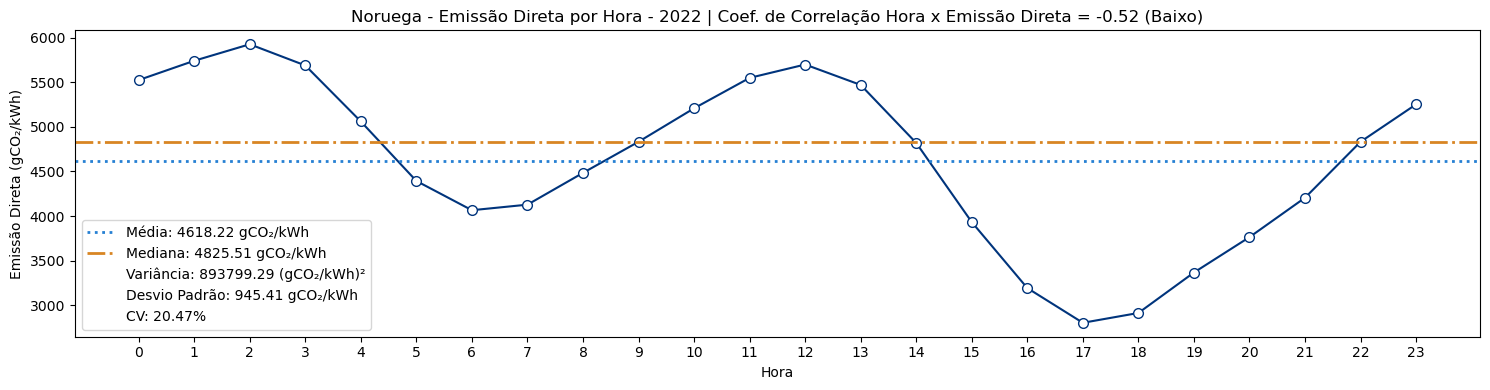

In [121]:
no_hourly_2022 = no_hourly[no_hourly.year == 2022]

correlation = no_hourly_2022.hour.corr(no_hourly_2022.total_direct_carbon_emission)
mean = no_hourly_2022.total_direct_carbon_emission.mean()
median = no_hourly_2022.total_direct_carbon_emission.median()
std = no_hourly_2022.total_direct_carbon_emission.std()
variance = std**2
cv = (std/mean)*100

plt.figure(figsize=(15, 4))
plt.plot(no_hourly_2022.hour, no_hourly_2022.total_direct_carbon_emission, 
         linewidth=1.5, color='#00347c', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

plt.axhline(mean, color='#2680d3', linestyle='dotted', linewidth=2, label=f'Média: {mean:.2f} gCO₂/kWh')
plt.axhline(median, color='#d88523', linestyle='dashdot', linewidth=2, label=f'Mediana: {median:.2f} gCO₂/kWh')

custom_lines = [
    Line2D([0], [0], color='none', label=f'Variância: {variance:.2f} (gCO₂/kWh)²'),
    Line2D([0], [0], color='none', label=f'Desvio Padrão: {std:.2f} gCO₂/kWh'),
    Line2D([0], [0], color='none', label=f'CV: {cv:.2f}%')
]

plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_lines)

plt.title(f'Noruega - Emissão Direta por Hora - 2022 | Coef. de Correlação Hora x Emissão Direta = {correlation:.2f} (Baixo)')
plt.xlabel('Hora')
plt.ylabel('Emissão Direta (gCO₂/kWh)')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

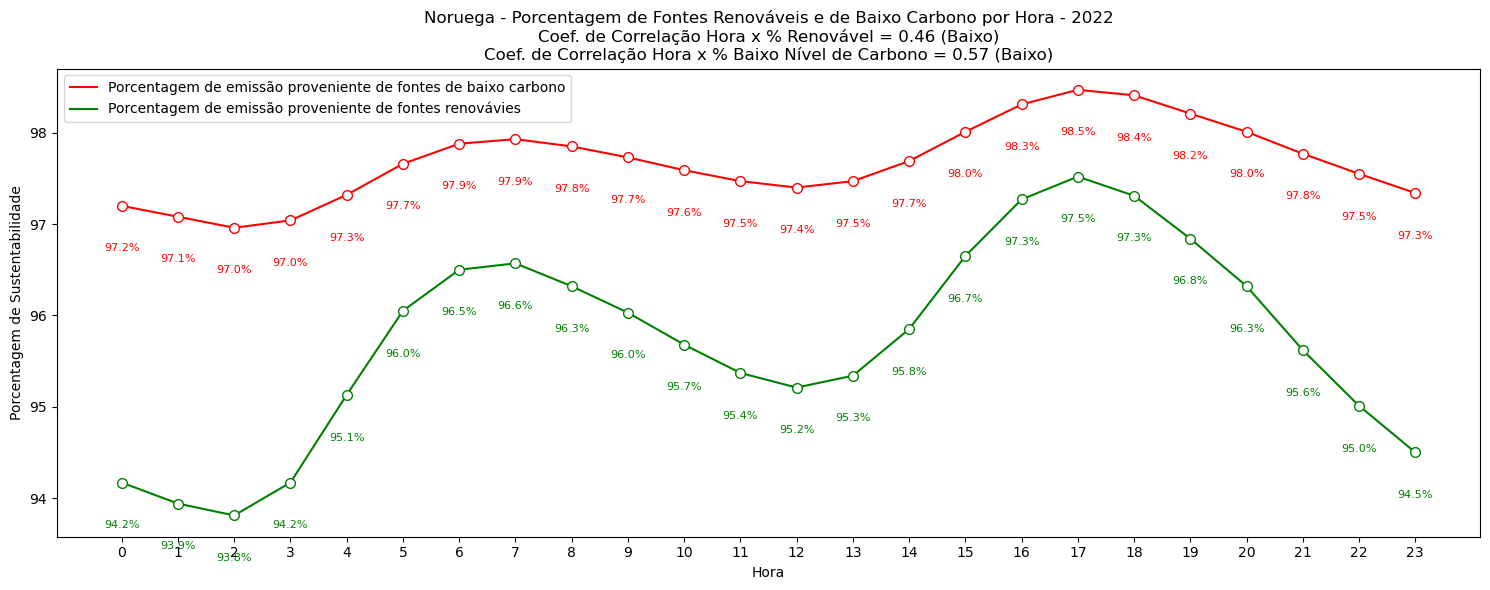

In [147]:
no_hourly_2022 = no_hourly[no_hourly.year == 2022]

correlation_renewable = no_hourly_2022.hour.corr(no_hourly_2022.avg_renewable_percentage)
correlation_low_carbon = no_hourly_2022.hour.corr(no_hourly_2022.avg_low_carbon_percentage)

plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=0.90)

plt.plot(no_hourly_2022.hour, no_hourly_2022.avg_renewable_percentage, 
         linewidth=1.5, color='green', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

for x, y in zip(no_hourly_2022.hour, no_hourly_2022.avg_renewable_percentage):
    plt.text(x, y - 0.5, f'{y:.1f}%', ha='center', fontsize=8, color='green')

plt.plot(no_hourly_2022.hour, no_hourly_2022.avg_low_carbon_percentage, 
         linewidth=1.5, color='red', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

for x, y in zip(no_hourly_2022.hour, no_hourly_2022.avg_low_carbon_percentage):
    plt.text(x, y - 0.5, f'{y:.1f}%', ha='center', fontsize=8, color='red')

custom_lines = [
    Line2D([0], [0], color='red', label='Porcentagem de emissão proveniente de fontes de baixo carbono'),
    Line2D([0], [0], color='green', label='Porcentagem de emissão proveniente de fontes renovávies'),
]

plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_lines)

plt.title(
    f'Noruega - Porcentagem de Fontes Renováveis e de Baixo Carbono por Hora - 2022\n'
    f'Coef. de Correlação Hora x % Renovável = {correlation_renewable:.2f} (Baixo)\n'
    f'Coef. de Correlação Hora x % Baixo Nível de Carbono = {correlation_low_carbon:.2f} (Baixo)'
)
plt.xlabel('Hora')
plt.ylabel('Porcentagem de Sustentabilidade')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

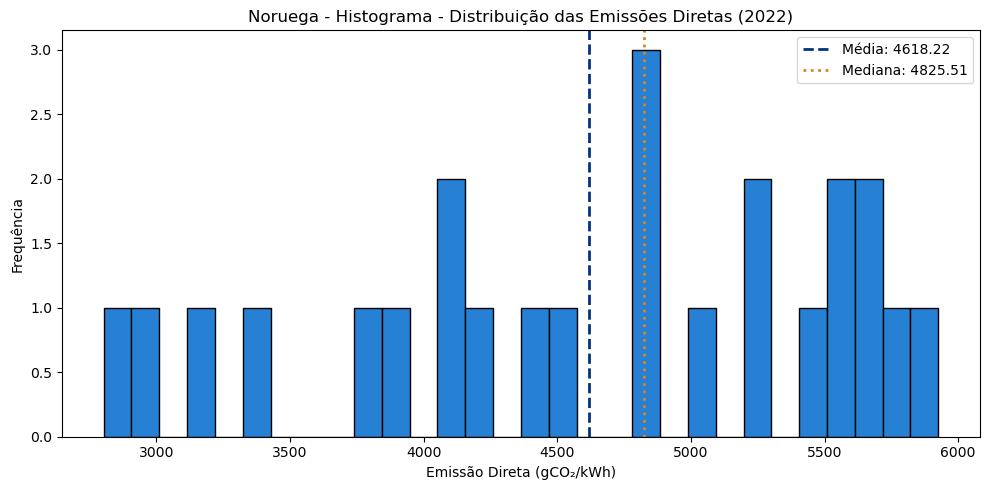

In [123]:
plt.figure(figsize=(10, 5))
plt.hist(no_hourly_2022.total_direct_carbon_emission, bins=30, color='#2680d3', edgecolor='black')
plt.axvline(no_hourly_2022.total_direct_carbon_emission.mean(), color='#00347c', linestyle='dashed', linewidth=2, label=f'Média: {no_hourly_2022.total_direct_carbon_emission.mean():.2f}')
plt.axvline(no_hourly_2022.total_direct_carbon_emission.median(), color='#d88523', linestyle='dotted', linewidth=2, label=f'Mediana: {no_hourly_2022.total_direct_carbon_emission.median():.2f}')
plt.title('Noruega - Histograma - Distribuição das Emissões Diretas (2022)')
plt.xlabel('Emissão Direta (gCO₂/kWh)')
plt.ylabel('Frequência')
plt.legend()
plt.tight_layout()
plt.show()

<Axes: ylabel='total_direct_carbon_emission'>

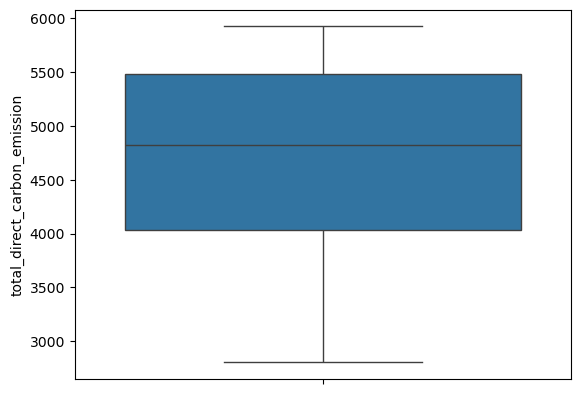

In [124]:
sns.boxplot(no_hourly_2022.total_direct_carbon_emission)

### 2023

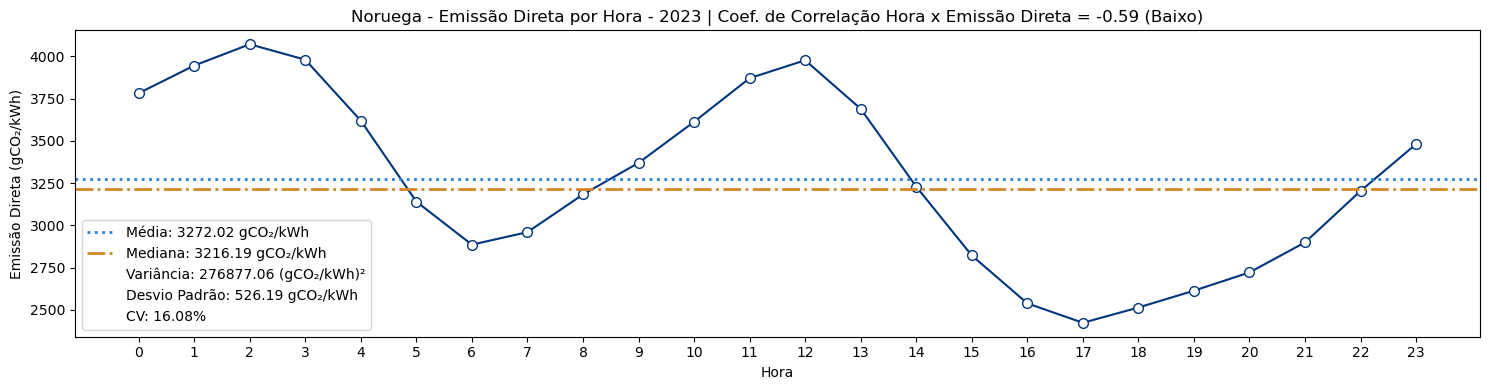

In [125]:
no_hourly_2023 = no_hourly[no_hourly.year == 2023]

correlation = no_hourly_2023.hour.corr(no_hourly_2023.total_direct_carbon_emission)
mean = no_hourly_2023.total_direct_carbon_emission.mean()
median = no_hourly_2023.total_direct_carbon_emission.median()
std = no_hourly_2023.total_direct_carbon_emission.std()
variance = std**2
cv = (std/mean)*100

plt.figure(figsize=(15, 4))
plt.plot(no_hourly_2023.hour, no_hourly_2023.total_direct_carbon_emission, 
         linewidth=1.5, color='#00347c', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

plt.axhline(mean, color='#2680d3', linestyle='dotted', linewidth=2, label=f'Média: {mean:.2f} gCO₂/kWh')
plt.axhline(median, color='#d88523', linestyle='dashdot', linewidth=2, label=f'Mediana: {median:.2f} gCO₂/kWh')

custom_lines = [
    Line2D([0], [0], color='none', label=f'Variância: {variance:.2f} (gCO₂/kWh)²'),
    Line2D([0], [0], color='none', label=f'Desvio Padrão: {std:.2f} gCO₂/kWh'),
    Line2D([0], [0], color='none', label=f'CV: {cv:.2f}%')
]

plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_lines)

plt.title(f'Noruega - Emissão Direta por Hora - 2023 | Coef. de Correlação Hora x Emissão Direta = {correlation:.2f} (Baixo)')
plt.xlabel('Hora')
plt.ylabel('Emissão Direta (gCO₂/kWh)')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

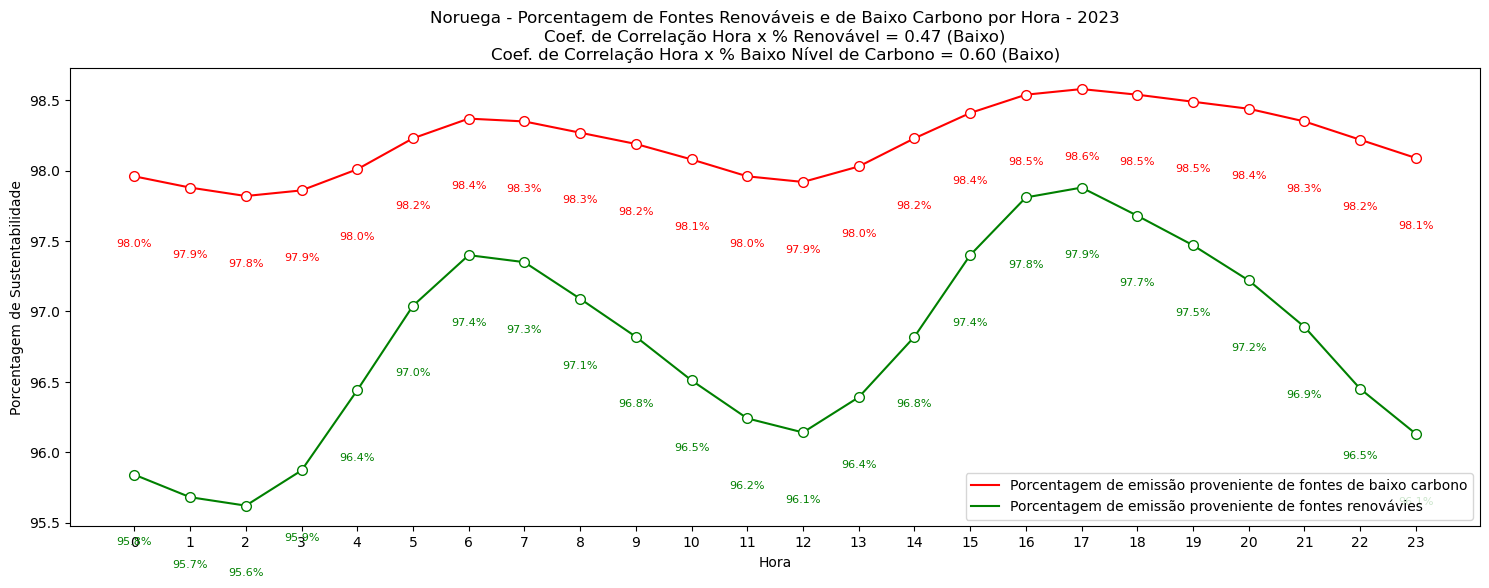

In [148]:
no_hourly_2023 = no_hourly[no_hourly.year == 2023]

correlation_renewable = no_hourly_2023.hour.corr(no_hourly_2023.avg_renewable_percentage)
correlation_low_carbon = no_hourly_2023.hour.corr(no_hourly_2023.avg_low_carbon_percentage)

plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=0.90)

plt.plot(no_hourly_2023.hour, no_hourly_2023.avg_renewable_percentage, 
         linewidth=1.5, color='green', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

for x, y in zip(no_hourly_2023.hour, no_hourly_2023.avg_renewable_percentage):
    plt.text(x, y - 0.5, f'{y:.1f}%', ha='center', fontsize=8, color='green')

plt.plot(no_hourly_2023.hour, no_hourly_2023.avg_low_carbon_percentage, 
         linewidth=1.5, color='red', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

for x, y in zip(no_hourly_2023.hour, no_hourly_2023.avg_low_carbon_percentage):
    plt.text(x, y - 0.5, f'{y:.1f}%', ha='center', fontsize=8, color='red')

custom_lines = [
    Line2D([0], [0], color='red', label='Porcentagem de emissão proveniente de fontes de baixo carbono'),
    Line2D([0], [0], color='green', label='Porcentagem de emissão proveniente de fontes renovávies'),
]

plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_lines)

plt.title(
    f'Noruega - Porcentagem de Fontes Renováveis e de Baixo Carbono por Hora - 2023\n'
    f'Coef. de Correlação Hora x % Renovável = {correlation_renewable:.2f} (Baixo)\n'
    f'Coef. de Correlação Hora x % Baixo Nível de Carbono = {correlation_low_carbon:.2f} (Baixo)'
)
plt.xlabel('Hora')
plt.ylabel('Porcentagem de Sustentabilidade')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

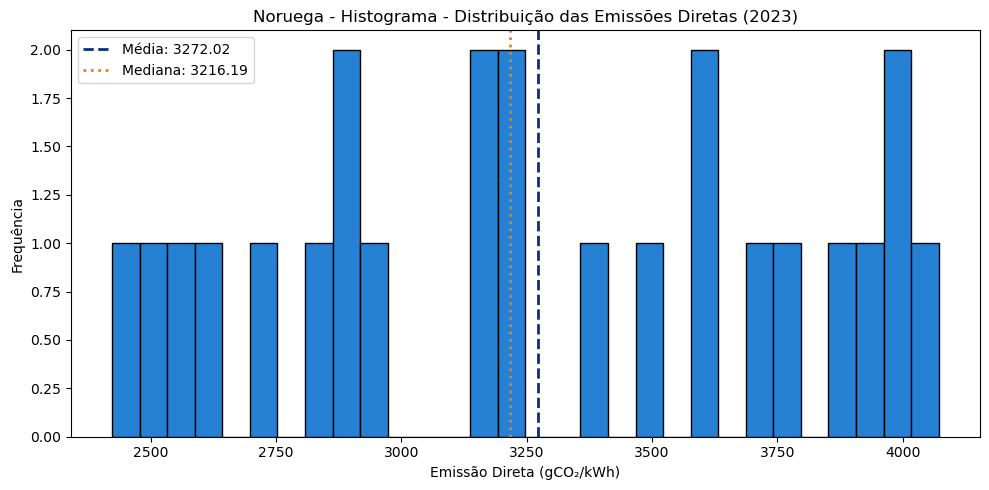

In [127]:
plt.figure(figsize=(10, 5))
plt.hist(no_hourly_2023.total_direct_carbon_emission, bins=30, color='#2680d3', edgecolor='black')
plt.axvline(no_hourly_2023.total_direct_carbon_emission.mean(), color='#00347c', linestyle='dashed', linewidth=2, label=f'Média: {no_hourly_2023.total_direct_carbon_emission.mean():.2f}')
plt.axvline(no_hourly_2023.total_direct_carbon_emission.median(), color='#d88523', linestyle='dotted', linewidth=2, label=f'Mediana: {no_hourly_2023.total_direct_carbon_emission.median():.2f}')
plt.title('Noruega - Histograma - Distribuição das Emissões Diretas (2023)')
plt.xlabel('Emissão Direta (gCO₂/kWh)')
plt.ylabel('Frequência')
plt.legend()
plt.tight_layout()
plt.show()

<Axes: ylabel='total_direct_carbon_emission'>

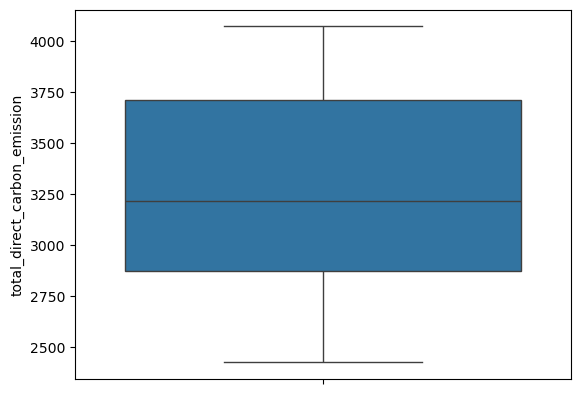

In [128]:
sns.boxplot(no_hourly_2023.total_direct_carbon_emission)

### 2024

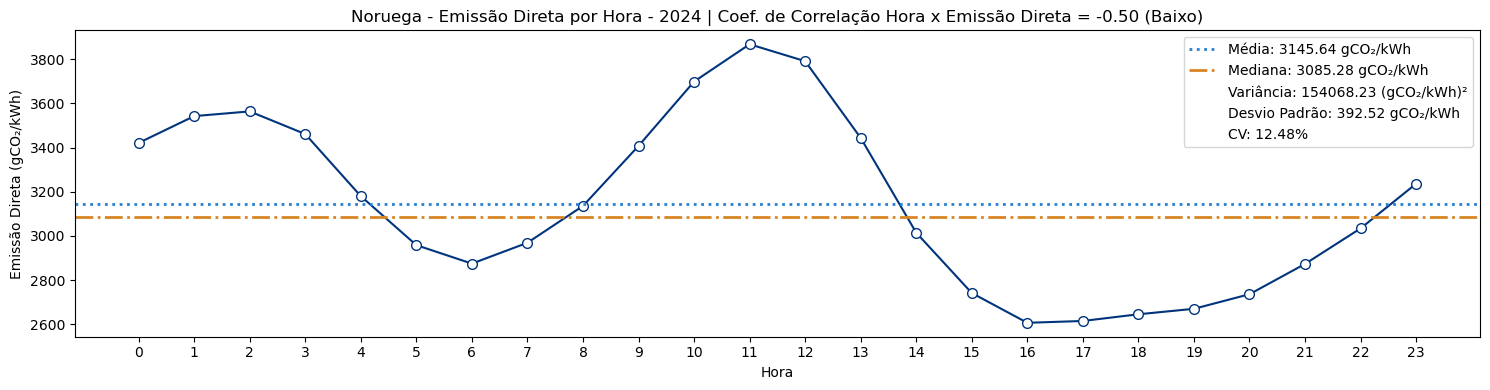

In [129]:
no_hourly_2024 = no_hourly[no_hourly.year == 2024]

correlation = no_hourly_2024.hour.corr(no_hourly_2024.total_direct_carbon_emission)
mean = no_hourly_2024.total_direct_carbon_emission.mean()
median = no_hourly_2024.total_direct_carbon_emission.median()
std = no_hourly_2024.total_direct_carbon_emission.std()
variance = std**2
cv = (std/mean)*100

plt.figure(figsize=(15, 4))
plt.plot(no_hourly_2024.hour, no_hourly_2024.total_direct_carbon_emission, 
         linewidth=1.5, color='#00347c', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

plt.axhline(mean, color='#2680d3', linestyle='dotted', linewidth=2, label=f'Média: {mean:.2f} gCO₂/kWh')
plt.axhline(median, color='#d88523', linestyle='dashdot', linewidth=2, label=f'Mediana: {median:.2f} gCO₂/kWh')

custom_lines = [
    Line2D([0], [0], color='none', label=f'Variância: {variance:.2f} (gCO₂/kWh)²'),
    Line2D([0], [0], color='none', label=f'Desvio Padrão: {std:.2f} gCO₂/kWh'),
    Line2D([0], [0], color='none', label=f'CV: {cv:.2f}%')
]

plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_lines)

plt.title(f'Noruega - Emissão Direta por Hora - 2024 | Coef. de Correlação Hora x Emissão Direta = {correlation:.2f} (Baixo)')
plt.xlabel('Hora')
plt.ylabel('Emissão Direta (gCO₂/kWh)')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

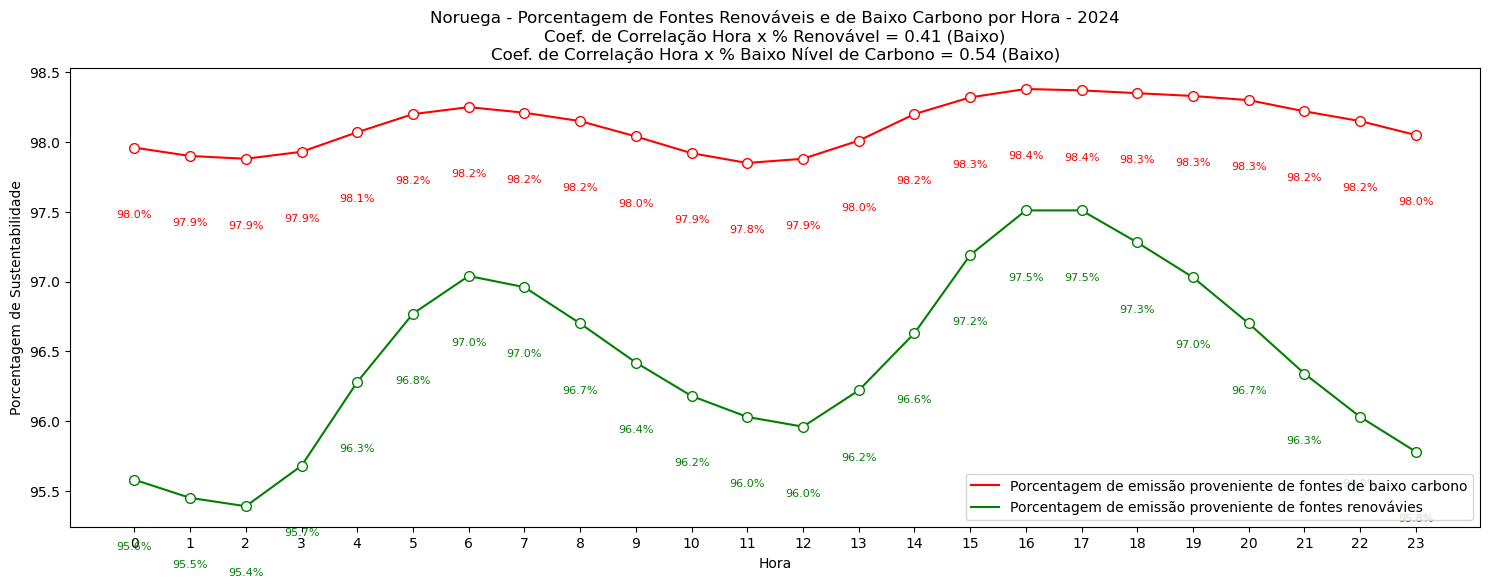

In [149]:
no_hourly_2024 = no_hourly[no_hourly.year == 2024]

correlation_renewable = no_hourly_2024.hour.corr(no_hourly_2024.avg_renewable_percentage)
correlation_low_carbon = no_hourly_2024.hour.corr(no_hourly_2024.avg_low_carbon_percentage)

plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=0.90)

plt.plot(no_hourly_2024.hour, no_hourly_2024.avg_renewable_percentage, 
         linewidth=1.5, color='green', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

for x, y in zip(no_hourly_2024.hour, no_hourly_2024.avg_renewable_percentage):
    plt.text(x, y - 0.5, f'{y:.1f}%', ha='center', fontsize=8, color='green')

plt.plot(no_hourly_2024.hour, no_hourly_2024.avg_low_carbon_percentage, 
         linewidth=1.5, color='red', marker='o', markersize=7, 
         markerfacecolor='white', markeredgewidth=1)

for x, y in zip(no_hourly_2024.hour, no_hourly_2024.avg_low_carbon_percentage):
    plt.text(x, y - 0.5, f'{y:.1f}%', ha='center', fontsize=8, color='red')

custom_lines = [
    Line2D([0], [0], color='red', label='Porcentagem de emissão proveniente de fontes de baixo carbono'),
    Line2D([0], [0], color='green', label='Porcentagem de emissão proveniente de fontes renovávies'),
]

plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_lines)

plt.title(
    f'Noruega - Porcentagem de Fontes Renováveis e de Baixo Carbono por Hora - 2024\n'
    f'Coef. de Correlação Hora x % Renovável = {correlation_renewable:.2f} (Baixo)\n'
    f'Coef. de Correlação Hora x % Baixo Nível de Carbono = {correlation_low_carbon:.2f} (Baixo)'
)
plt.xlabel('Hora')
plt.ylabel('Porcentagem de Sustentabilidade')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

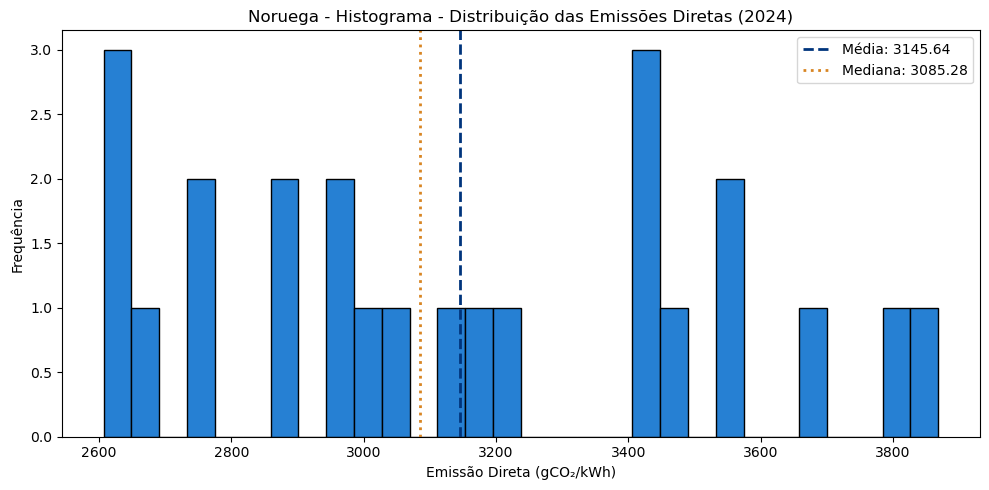

In [131]:
plt.figure(figsize=(10, 5))
plt.hist(no_hourly_2024.total_direct_carbon_emission, bins=30, color='#2680d3', edgecolor='black')
plt.axvline(no_hourly_2024.total_direct_carbon_emission.mean(), color='#00347c', linestyle='dashed', linewidth=2, label=f'Média: {no_hourly_2024.total_direct_carbon_emission.mean():.2f}')
plt.axvline(no_hourly_2024.total_direct_carbon_emission.median(), color='#d88523', linestyle='dotted', linewidth=2, label=f'Mediana: {no_hourly_2024.total_direct_carbon_emission.median():.2f}')
plt.title('Noruega - Histograma - Distribuição das Emissões Diretas (2024)')
plt.xlabel('Emissão Direta (gCO₂/kWh)')
plt.ylabel('Frequência')
plt.legend()
plt.tight_layout()
plt.show()

<Axes: ylabel='total_direct_carbon_emission'>

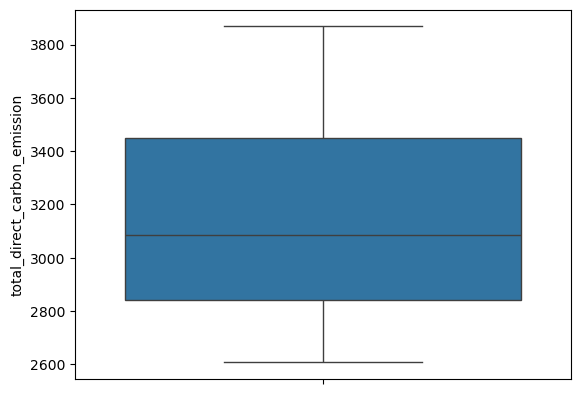

In [132]:
sns.boxplot(no_hourly_2024.total_direct_carbon_emission)